In [1]:
import math, sys
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, DataCollatorForLanguageModeling
from datasets import load_dataset

2024-07-20 15:51:42.327399: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-20 15:51:42.368669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 15:51:42.368701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 15:51:42.369800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 15:51:42.376393: I tensorflow/core/platform/cpu_feature_guar

In [2]:
LiGO_bool = True
emb_size = 128
new_emb_size = 256
block_size = 64
multi_heads = 2
batch_size = 512
epochs = 3
learning_rate = 3e-4
device = torch.device('cuda:1')
num_small_layers = 4
multi_heads = 2
num_large_layers = 8
batches_per_epoch = 10

In [3]:
# Dataset wikitext-2
dataset = load_dataset('wikitext', 'wikitext-2-v1')

# Dataset wikitext-103
# dataset = load_dataset('wikitext', 'wikitext-103-raw-v1')

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# padding token 
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size = len(tokenizer)

def tokenize_function(examples):
    return tokenizer(examples['text'], return_tensors='pt', truncation=True, padding='max_length', max_length=block_size)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, collate_fn=data_collator)


In [4]:
train_dataloader = list(train_dataloader)
val_dataloader = list(val_dataloader)

In [5]:
@torch.no_grad()
def validate(mdl, dataloader, device=device):
    loss_fn = torch.nn.CrossEntropyLoss()
    mdl.eval()
    total_loss = 0
    num_batches = 0
    ix = torch.randint(len(dataloader), tuple([5]))
    # dataloader = list(dataloader)
    for index in ix:
        batch = dataloader[index]
        inputs = batch["input_ids"].detach().clone().detach().squeeze(1).to(device)
        labels = batch["labels"].detach().clone().detach().to(device)
        outputs = mdl(inputs)
        loss = loss_fn(outputs.view(-1, vocab_size), labels.view(-1))
        total_loss += loss.item()
        num_batches += 1
        del loss
        del outputs
    return total_loss / num_batches

@torch.enable_grad()
def train(mdl, optim, epochs, train_dataloader=train_dataloader, val_dataloader=val_dataloader, device=device):
    loss_fn = torch.nn.CrossEntropyLoss()
    mdl.to(device)
    val_losses_epoch = []
    # train_dataloader = list(train_dataloader)
    for epoch in range(epochs):
        mdl.train()
        total_loss = 0
        num_batches = 0
        ix = torch.randint(len(train_dataloader), tuple([batches_per_epoch]))
        for index in ix:
            batch = train_dataloader[index]
            # print(f"Processing Batch: {index} in Epoch: {epoch}")
            inputs = batch["input_ids"].detach().clone().detach().to(device).squeeze(1)
            optim.zero_grad()
            outputs = mdl(inputs)
            labels = batch["labels"].detach().clone().detach().to(device)
            loss = loss_fn(outputs.view(-1, vocab_size), labels.view(-1))
            loss.backward()
            optim.step()
            total_loss += loss.item()
            num_batches += 1
            del loss
            del outputs
        avg_loss = total_loss / num_batches
        val_loss = validate(mdl, val_dataloader, device=device)
        val_losses_epoch.append(val_loss)
        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return val_losses_epoch

In [6]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [7]:
class AttentionHead(torch.nn.Module):
    def __init__(self, big=False):
        super(AttentionHead, self).__init__()
        self.k = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.q = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.v = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
    def forward(self, e):
        keys = self.k(e)
        queries = self.q(e)
        values = self.v(e)
        ret = keys @ queries.transpose(1, 2)*(1.0/math.sqrt(keys.size(-1)))
        ret = torch.masked_fill(ret, self.tril==0, -torch.inf)
        ret = torch.softmax(ret, 2)
        ret = ret @ values
        return ret

In [8]:
class MultiHead(torch.nn.Module):
    def __init__(self, big=False):
        super(MultiHead, self).__init__()
        self.head1 = AttentionHead(big)
        self.head2 = AttentionHead(big)
        self.mh_lin = torch.nn.Linear(multi_heads*(new_emb_size if big else emb_size), new_emb_size if big else emb_size, bias=False)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        x1 = self.head1(inp)
        x2 = self.head2(inp)
        return self.mh_lin(self.drop(torch.cat([x1,x2], dim=2))).relu()


In [9]:
class Block(torch.nn.Module):
    def __init__(self, big=False):
        super(Block, self).__init__()
        self.multihead = MultiHead(big)
        self.l_norm_1 = torch.nn.LayerNorm(new_emb_size if big else emb_size)
        self.l_norm_2 = torch.nn.LayerNorm(new_emb_size if big else emb_size)
        self.ffn = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        m = self.l_norm_1(inp + self.multihead(inp))
        m = self.l_norm_2(m + self.ffn(self.drop(m)).relu())
        return m

In [10]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_size)
        self.pe = PositionalEncoding(d_model=emb_size)
        self.block1 = Block()
        self.block2 = Block()
        self.block3 = Block()
        self.block4 = Block()
        self.f_lin = torch.nn.Linear(emb_size, vocab_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        r = self.f_lin(self.drop(m))
        return r

In [11]:
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [12]:
small_model_curve = train(model, optimizer, 10)

Epoch 1, Train Loss: 9.9972, Val Loss: 8.8549
Epoch 2, Train Loss: 8.3246, Val Loss: 7.3921
Epoch 3, Train Loss: 7.0151, Val Loss: 6.2205
Epoch 4, Train Loss: 5.9484, Val Loss: 5.3980
Epoch 5, Train Loss: 5.1729, Val Loss: 4.5981
Epoch 6, Train Loss: 4.5596, Val Loss: 4.0080
Epoch 7, Train Loss: 4.0960, Val Loss: 3.5522
Epoch 8, Train Loss: 3.7145, Val Loss: 3.1477
Epoch 9, Train Loss: 3.3227, Val Loss: 2.7479
Epoch 10, Train Loss: 2.9870, Val Loss: 2.4471


In [14]:
k_params = torch.empty((0,emb_size*emb_size)).to(device)
q_params = torch.empty((0,emb_size*emb_size)).to(device)
v_params = torch.empty((0,emb_size*emb_size)).to(device)
lin_params = torch.empty((0, 2*emb_size*emb_size)).to(device)
ffn_w_params = torch.empty((0, emb_size*emb_size)).to(device)
ffn_b_params = torch.empty((0, emb_size)).to(device)
l_norm_w_params = torch.empty((0, emb_size)).to(device)
l_norm_b_params = torch.empty((0, emb_size)).to(device)
for i in model.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)

In [15]:
class FusedEmbedding(torch.nn.Module):
    def __init__(self, emb_params, static=True, width=False, width_static=True):
        super(FusedEmbedding, self).__init__()
        self.static = static
        self.width_static = width_static
        self.width=width
        if static:
            if width:
                if width_static:
                    self.emb_params = torch.cat((emb_params, emb_params)).view(vocab_size, -1)
                else:
                    self.emb_params = emb_params.view(vocab_size, -1)
                    self.width_w = torch.nn.Linear(emb_size, new_emb_size, bias=False)
            else:
                self.emb_params = emb_params.view(vocab_size, -1)
        else:
            self.width = width
            self.emb_params = emb_params
    def forward(self, inp):
        emb = self.emb_params
        if self.static:
            if self.width:
                if self.width_static:
                    return torch.nn.functional.embedding(inp, emb)
                return torch.nn.functional.embedding(inp, self.width_w(emb))
        emb = emb.view(vocab_size, -1)
        return torch.nn.functional.embedding(inp, emb)

In [16]:
class FusedLin(torch.nn.Module):
    def __init__(self, num_layers, in_dim, out_dim, small_params_w, small_params_b = None, static = False, width_static=True, width=False, old_in_dim = emb_size, old_out_dim = emb_size):
        super( FusedLin, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.static = static
        self.width = width
        self.old_in_dim = old_in_dim
        self.old_out_dim = old_out_dim
        self.width_static = width_static
        self.final = True if out_dim == vocab_size else False
        if not self.final and static:
            if width:
                if width_static:
                    self.register_buffer('small_params_w', torch.kron(torch.eye(int(out_dim/old_out_dim), int(in_dim/old_in_dim)).to(device), small_params_w).view(out_dim, in_dim))
                    if small_params_b is not None:
                        if old_out_dim == out_dim:
                            self.register_buffer('small_params_b', small_params_b)
                        else:
                            self.register_buffer('small_params_b', torch.cat((small_params_b, small_params_b)))
                    else:
                        self.small_params_b = None
                else:
                    self.register_buffer('small_params_w', small_params_w)
                    self.width_wa = torch.nn.Linear(old_out_dim, out_dim, bias=False) if width else None
                    self.width_wb = torch.nn.Linear(old_in_dim, in_dim, bias=False) if width else None
                    if small_params_b is not None:
                        self.register_buffer('small_params_b', small_params_b)
                    else:
                        self.small_params_b = None
                    self.width_b = torch.nn.Linear(old_out_dim, out_dim, bias=False) if width and small_params_b is not None else None
            else:
                self.register_buffer('small_params_w', small_params_w.view(out_dim, in_dim))
                if small_params_b is not None:
                    self.register_buffer('small_params_b', small_params_b)
                else:
                    self.small_params_b = None
        else:
            self.width_wa = torch.nn.Linear(old_out_dim, out_dim, bias=False) if width and not self.final else None
            self.width_wb = torch.nn.Linear(old_in_dim, in_dim, bias=False) if width else None
            self.width_b = torch.nn.Linear(old_out_dim, out_dim, bias=False) if width and small_params_b is not None and not self.final else None
            if not self.final:
                self.lin_w = torch.nn.Parameter(torch.rand(num_layers))
                if small_params_b is not None:
                    self.lin_b = torch.nn.Parameter(torch.rand(num_layers))
            self.register_buffer('small_params_w', small_params_w)
            if small_params_b is not None:
                self.register_buffer('small_params_b', small_params_b)
            else:
                self.small_params_b = None
    def forward(self, inp):
        if self.static and not self.final:
            weight=self.small_params_w
            bias=self.small_params_b
            if not self.width_static:
                weight = self.width_wb(weight.view(self.old_out_dim, self.old_in_dim))
                weight = self.width_wa(weight.T).T
                if bias is not None:
                    bias = self.width_b(bias)
            return torch.nn.functional.linear(inp, weight=weight, bias=bias)
        if self.final:
            weight = self.small_params_w
            bias = self.small_params_b
        else:
            weight = self.small_params_w.T @ self.lin_w
            bias = None
            if self.small_params_b is not None:
                bias = self.small_params_b.T@self.lin_b    
        if self.width:
            if not self.final:
                weight = self.width_wb(weight.view(self.old_out_dim, self.old_in_dim))
                weight = self.width_wa(weight.T).T
            else:
                weight = self.width_wb(weight.view(self.old_out_dim, self.old_in_dim))
        if self.width_b is not None:
            bias = self.width_b(bias)
        weight = weight.view(self.out_dim, self.in_dim)
        return torch.nn.functional.linear(inp, weight, bias = bias)

In [17]:
class FusedNorm(torch.nn.Module):
    def __init__(self, num_layers, small_params_w, small_params_b, static=False, width_static = True, width=False):
        super(FusedNorm, self).__init__()
        self.static = static
        self.width = width
        self.width_static = width_static
        if not static:
            self.register_buffer('small_params_w', small_params_w)
            self.register_buffer('small_params_b', small_params_b)
            self.lin_w = torch.nn.Parameter(torch.randn(num_layers))
            self.lin_b = torch.nn.Parameter(torch.randn(num_layers))
            if width:
                self.width_w = torch.nn.Linear(emb_size, new_emb_size, bias=False)
                self.width_b = torch.nn.Linear(emb_size, new_emb_size, bias=False)
        else:
            if width:
                if width_static:
                    self.register_buffer('small_params_w', torch.cat((small_params_w, small_params_w)))
                    self.register_buffer('small_params_b', torch.cat((small_params_b, small_params_b)))
                else:
                    self.register_buffer('small_params_w', small_params_w)
                    self.register_buffer('small_params_b', small_params_b)
                    self.width_w = torch.nn.Linear(emb_size, new_emb_size, bias=False)
                    self.width_b = torch.nn.Linear(emb_size, new_emb_size, bias=False)
            else:
                self.register_buffer('small_params_w', small_params_w)
                self.register_buffer('small_params_b', small_params_b)
    def forward(self, inp):
        if self.static:
            weight = self.small_params_w
            bias = self.small_params_b
            e_s = emb_size if not self.width else new_emb_size
            if not self.width_static:
                weight = self.width_w(weight)
                bias = self.width_b(bias)
            return torch.nn.functional.layer_norm(inp, tuple([e_s]), weight=weight, bias=bias)
        weight = self.small_params_w.T @ self.lin_w
        bias = self.small_params_b.T @ self.lin_b
        if self.width:
            weight = self.width_w(weight)
            bias = self.width_b(bias)
        e_s = emb_size if not self.width else new_emb_size
        return torch.nn.functional.layer_norm(inp, tuple([e_s]), weight=weight, bias=bias)

In [18]:
class FusedAttentionHead(torch.nn.Module):
    def __init__(self, static=False, layerNum=None, width=False, width_static = True):
        super( FusedAttentionHead, self).__init__()
        self.static = static
        self.width_static = width_static
        if not static:
            self.k = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, k_params, width=width, width_static=width_static)
            self.q = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, q_params, width=width, width_static=width_static)
            self.v = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, v_params, width=width, width_static=width_static)
        else:
            self.k = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, k_params[layerNum], static=True, width=width, width_static=width_static)
            self.q = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, q_params[layerNum], static=True, width=width, width_static=width_static)
            self.v = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, v_params[layerNum], static=True, width=width, width_static=width_static)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
    def forward(self, e):
        keys = self.k(e)
        queries = self.q(e)
        values = self.v(e)
        ret = keys @ queries.transpose(1, 2)*(1.0/math.sqrt(keys.size(-1)))
        ret = torch.masked_fill(ret, self.tril==0, -torch.inf)
        ret = torch.softmax(ret, 2)
        ret = ret @ values
        return ret


In [19]:
class FusedMultiHead(torch.nn.Module):
    def __init__(self, static=False, layerNum=None, width=False, width_static = True):
        super( FusedMultiHead, self).__init__()
        self.drop = torch.nn.Dropout(0.1)
        self.width_static = width_static
        if not static:
            self.head1 = FusedAttentionHead(width=width, width_static=width_static)
            self.head2 = FusedAttentionHead(width=width, width_static=width_static)
            self.mh_lin = FusedLin(num_small_layers, multi_heads*(emb_size if not width else new_emb_size), emb_size if not width else new_emb_size, lin_params, width=width, old_in_dim=multi_heads*emb_size , old_out_dim=emb_size, width_static=width_static)
        else:
            self.head1 = FusedAttentionHead(static=True, layerNum=2*layerNum, width=width, width_static=width_static)
            self.head2 = FusedAttentionHead(static=True, layerNum=2*layerNum+1, width=width, width_static=width_static)
            self.mh_lin = FusedLin(num_small_layers, multi_heads*(emb_size if not width else new_emb_size), emb_size if not width else new_emb_size, lin_params[layerNum], static=True, width=width, width_static=width_static, old_in_dim=multi_heads*emb_size, old_out_dim=emb_size)
    def forward(self, inp):
        x1 = self.head1(inp)
        x2 = self.head2(inp)
        return self.mh_lin(self.drop(torch.cat([x1,x2], dim=2))).relu()

In [20]:
class FusedBlock(torch.nn.Module):
    def __init__(self, static=False, layerNum=None, width=False, width_static = True):
        super(FusedBlock, self).__init__()
        self.static = static
        self.width_static = width_static
        self.drop = torch.nn.Dropout(0.1)
        if not static:
            self.multiHead = FusedMultiHead(width=width, width_static=width_static)
            self.norm_1 = FusedNorm(num_small_layers*2, l_norm_w_params, l_norm_b_params, width=width, width_static=width_static)
            self.norm_2 = FusedNorm(num_small_layers*2, l_norm_w_params, l_norm_b_params, width=width, width_static=width_static)
            self.ffn = FusedLin(num_small_layers, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, ffn_w_params, ffn_b_params, width=width, width_static=width_static)
        else:
            self.multiHead = FusedMultiHead(static=True, layerNum=layerNum, width=width, width_static=width_static)
            self.norm_1 = FusedNorm(num_small_layers*2, l_norm_w_params[layerNum*2], l_norm_b_params[layerNum*2], static=True, width=width, width_static=width_static)
            self.norm_2 = FusedNorm(num_small_layers*2, l_norm_w_params[layerNum*2+1], l_norm_b_params[layerNum*2+1], static=True, width=width, width_static=width_static)
            self.ffn = FusedLin(num_small_layers, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, ffn_w_params[layerNum], ffn_b_params[layerNum], static=True, width=width, width_static=width_static)
    def forward(self, inp):
        m = self.norm_1(inp + self.multiHead(inp))
        m = self.norm_2(m + self.ffn(self.drop(m)).relu())
        return m
        

In [21]:
class StackLiGO(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(StackLiGO, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten().clone(), width=width, static=True)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(static=True, layerNum=0, width=width)
        self.block2 = FusedBlock(static=True, layerNum=1, width=width)
        self.block3 = FusedBlock(static=True, layerNum=2, width=width)
        self.block4 = FusedBlock(static=True, layerNum=3, width=width)
        self.block5 = FusedBlock(width=width)
        self.block6 = FusedBlock(width=width)
        self.block7 = FusedBlock(width=width)
        self.block8 = FusedBlock(width=width)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten().clone(), small_params_b=model.f_lin.bias.clone(), width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [22]:
class StackLiGOv2(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(StackLiGOv2, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten().clone(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(static=True, layerNum=0, width=width, width_static=False)
        self.block2 = FusedBlock(static=True, layerNum=1, width=width, width_static=False)
        self.block3 = FusedBlock(static=True, layerNum=2, width=width, width_static=False)
        self.block4 = FusedBlock(static=True, layerNum=3, width=width, width_static=False)
        self.block5 = FusedBlock(width=width)
        self.block6 = FusedBlock(width=width)
        self.block7 = FusedBlock(width=width)
        self.block8 = FusedBlock(width=width)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten().clone(), small_params_b=model.f_lin.bias.clone(), width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [23]:
class LiGO(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(LiGO, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten().clone(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(width=width, width_static=False)
        self.block2 = FusedBlock(width=width, width_static=False)
        self.block3 = FusedBlock(width=width, width_static=False)
        self.block4 = FusedBlock(width=width, width_static=False)
        self.block5 = FusedBlock(width=width, width_static=False)
        self.block6 = FusedBlock(width=width, width_static=False)
        self.block7 = FusedBlock(width=width, width_static=False)
        self.block8 = FusedBlock(width=width, width_static=False)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten().clone(), small_params_b=model.f_lin.bias.clone(), width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [24]:
class LiGO_W(torch.nn.Module):
    def __init__(self, width=True) -> None:
        super(LiGO_W, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(width=width, static=True, layerNum=0, width_static=False)
        self.block2 = FusedBlock(width=width, static=True, layerNum=1, width_static=False)
        self.block3 = FusedBlock(width=width, static=True, layerNum=2, width_static=False)
        self.block4 = FusedBlock(width=width, static=True, layerNum=3, width_static=False)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten(), small_params_b=model.f_lin.bias, width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        return self.f_lin(self.drop(m))

In [25]:
class CrossLiGO(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(CrossLiGO, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten().detach().clone(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(static=True, layerNum=0, width=width)
        self.block3 = FusedBlock(static=True, layerNum=1, width=width)
        self.block5 = FusedBlock(static=True, layerNum=2, width=width)
        self.block7 = FusedBlock(static=True, layerNum=3, width=width)
        self.block2 = FusedBlock(width=width, width_static=False)
        self.block4 = FusedBlock(width=width, width_static=False)
        self.block6 = FusedBlock(width=width, width_static=False)
        self.block8 = FusedBlock(width=width, width_static=False)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten().clone().to(device), small_params_b=model.f_lin.bias.detach().clone().to(device), width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [26]:
class CrossLiGOv2(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(CrossLiGOv2, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten().clone(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(static=True, layerNum=0, width=width, width_static=False)
        self.block3 = FusedBlock(static=True, layerNum=1, width=width, width_static=False)
        self.block5 = FusedBlock(static=True, layerNum=2, width=width, width_static=False)
        self.block7 = FusedBlock(static=True, layerNum=3, width=width, width_static=False)
        self.block2 = FusedBlock(width=width, width_static=False)
        self.block4 = FusedBlock(width=width, width_static=False)
        self.block6 = FusedBlock(width=width, width_static=False)
        self.block8 = FusedBlock(width=width, width_static=False)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten().clone(), small_params_b=model.f_lin.bias.clone(), width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [27]:
class BigModel(torch.nn.Module):
    def __init__(self, big=False):
        super(BigModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, new_emb_size if big else emb_size)
        self.pe = PositionalEncoding(d_model= new_emb_size if big else emb_size)
        self.block1 = Block(big=big)
        self.block2 = Block(big=big)
        self.block3 = Block(big=big)
        self.block4 = Block(big=big)
        self.block5 = Block(big=big)
        self.block6 = Block(big=big)
        self.block7 = Block(big=big)
        self.block8 = Block(big=big)
        self.f_lin = torch.nn.Linear(new_emb_size if big else emb_size, vocab_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        r = self.f_lin(self.drop(m))
        return r

In [28]:
@torch.no_grad()
def initLiGO(stackLiGO, bigModel):
    # Embedding layer
    emb = stackLiGO.emb.emb_params
    if stackLiGO.emb.width and not stackLiGO.emb.width_static:
        emb = stackLiGO.emb.width_w(emb)
    setattr(bigModel.embedding, 'weight', torch.nn.Parameter(emb, requires_grad=True).to(device))
    # Final Linear layer
    f_lin_w = stackLiGO.f_lin.small_params_w.view(vocab_size, -1)
    f_lin_b = stackLiGO.f_lin.small_params_b
    if stackLiGO.f_lin.width:
        f_lin_w = (stackLiGO.f_lin.width_wb(f_lin_w))
        # f_lin_w = (stackLiGO.f_lin.width_wa(f_lin_w.T)).T     Issues with big vocab size
        # f_lin_b = stackLiGO.f_lin.width_b.weight@f_lin_b
    setattr(bigModel.f_lin, 'weight', torch.nn.Parameter(f_lin_w.view(vocab_size, -1), requires_grad=True).to(device))
    setattr(bigModel.f_lin, 'bias', torch.nn.Parameter(f_lin_b, requires_grad=True).to(device))
    num_layers = num_large_layers if type(stackLiGO) is not LiGO_W else num_small_layers
    for i in range(1, num_layers+1):
        fused_block = getattr(stackLiGO, f'block{i}')
        big_block = getattr(bigModel, f'block{i}')
        # Setting FFN Weights
        if fused_block.ffn.static:
            if fused_block.ffn.width:
                if fused_block.ffn.width_static:
                    fb_w = fused_block.ffn.small_params_w.view(new_emb_size, new_emb_size)
                    fb_b = fused_block.ffn.small_params_b
                else:
                    fb_w = fused_block.ffn.small_params_w.view(emb_size, emb_size)
                    fb_b = fused_block.ffn.small_params_b
                    fb_w = fused_block.ffn.width_wb(fb_w)
                    fb_w = fused_block.ffn.width_wa(fb_w.T).T
                    fb_b = fused_block.ffn.width_b.weight@fb_b
            else:
                fb_w = fused_block.ffn.small_params_w.view(emb_size, emb_size)
                fb_b = fused_block.ffn.small_params_b
        else:
            fb_w = (ffn_w_params.T@fused_block.ffn.lin_w).view(emb_size, emb_size)
            fb_b = (ffn_b_params.T@fused_block.ffn.lin_b)
            if fused_block.ffn.width:
                fb_w = fused_block.ffn.width_wb(fb_w)
                fb_w = fused_block.ffn.width_wa(fb_w.T).T
                fb_b = fused_block.ffn.width_b.weight@fb_b
        setattr(big_block.ffn, 'weight', torch.nn.Parameter(fb_w, requires_grad=True).to(device))
        setattr(big_block.ffn, 'bias', torch.nn.Parameter(fb_b, requires_grad=True).to(device))
        # Setting Norm Layers
        if fused_block.static:
            n_w_1 = fused_block.norm_1.small_params_w
            n_b_1 = fused_block.norm_1.small_params_b
            n_w_2 = fused_block.norm_2.small_params_w
            n_b_2 = fused_block.norm_2.small_params_b
            if not fused_block.width_static:
                n_w_1 = fused_block.norm_1.width_w.weight@n_w_1
                n_b_1 = fused_block.norm_1.width_b.weight@n_b_1
                n_w_2 = fused_block.norm_2.width_w.weight@n_w_2
                n_b_2 = fused_block.norm_2.width_b.weight@n_b_2  
        else:
            n_w_1 = (l_norm_w_params.T@fused_block.norm_1.lin_w)
            n_b_1 = (l_norm_b_params.T@fused_block.norm_1.lin_b)
            n_w_2 = (l_norm_w_params.T@fused_block.norm_2.lin_w)
            n_b_2 = (l_norm_b_params.T@fused_block.norm_2.lin_b)
            if fused_block.norm_1.width:
                n_w_1 = fused_block.norm_1.width_w.weight@n_w_1
                n_b_1 = fused_block.norm_1.width_b.weight@n_b_1
                n_w_2 = fused_block.norm_2.width_w.weight@n_w_2
                n_b_2 = fused_block.norm_2.width_b.weight@n_b_2
        setattr(big_block.l_norm_1, 'weight', torch.nn.Parameter(n_w_1, requires_grad=True).to(device))
        setattr(big_block.l_norm_1, 'bias', torch.nn.Parameter(n_b_1, requires_grad=True).to(device))
        setattr(big_block.l_norm_2, 'weight', torch.nn.Parameter(n_w_2, requires_grad=True).to(device))
        setattr(big_block.l_norm_2, 'bias', torch.nn.Parameter(n_b_2, requires_grad=True).to(device))
        # Setting Multi-Head Attention
        if fused_block.static:
            mh = fused_block.multiHead.mh_lin.small_params_w
            if not fused_block.width_static:
                mh = fused_block.multiHead.mh_lin.width_wb(mh.view(emb_size, multi_heads*emb_size))
                mh = fused_block.multiHead.mh_lin.width_wa(mh.T).T
        else:
            mh = (lin_params.T@fused_block.multiHead.mh_lin.lin_w).view(emb_size, emb_size*multi_heads)
            if fused_block.multiHead.mh_lin.width:
                mh = fused_block.multiHead.mh_lin.width_wb(mh)
                mh = fused_block.multiHead.mh_lin.width_wa(mh.T).T
        setattr(big_block.multihead.mh_lin, 'weight', torch.nn.Parameter(mh, requires_grad=True))
        for h in range(1, multi_heads+1):
            head = getattr(big_block.multihead, f'head{h}')
            fused_head = getattr(fused_block.multiHead, f'head{h}')
            if fused_head.static:
                k = fused_head.k.small_params_w
                q = fused_head.q.small_params_w
                v = fused_head.v.small_params_w
                if not fused_block.width_static:
                    k = fused_head.k.width_wb(k.view(emb_size, emb_size))
                    k = fused_head.k.width_wa(k.T).T
                    q = fused_head.q.width_wb(q.view(emb_size, emb_size))
                    q = fused_head.q.width_wa(q.T).T
                    v = fused_head.v.width_wb(v.view(emb_size, emb_size))
                    v = fused_head.v.width_wa(v.T).T
            else:
                k = (k_params.T@fused_head.k.lin_w).view(emb_size, emb_size)
                q = (q_params.T@fused_head.q.lin_w).view(emb_size, emb_size)
                v = (v_params.T@fused_head.v.lin_w).view(emb_size, emb_size)
                if fused_head.k.width:
                    k = fused_head.k.width_wb(k)
                    k = fused_head.k.width_wa(k.T).T
                    q = fused_head.q.width_wb(q)
                    q = fused_head.q.width_wa(q.T).T
                    v = fused_head.v.width_wb(v)
                    v = fused_head.v.width_wa(v.T).T
            setattr(head.k, 'weight', torch.nn.Parameter(k, requires_grad=True).to(device))
            setattr(head.q, 'weight', torch.nn.Parameter(q, requires_grad=True).to(device))
            setattr(head.v, 'weight', torch.nn.Parameter(v, requires_grad=True).to(device))

CrossLiGO depth+width

In [29]:
cl_dw = CrossLiGO(width=True).to(device)
optim_ldw = torch.optim.Adam(cl_dw.parameters(), lr=1e-3)

In [30]:
_=train(cl_dw, optim_ldw, 5)

Epoch 1, Train Loss: 8.1850, Val Loss: 6.8372
Epoch 2, Train Loss: 6.3931, Val Loss: 5.2509
Epoch 3, Train Loss: 5.1054, Val Loss: 4.1294
Epoch 4, Train Loss: 4.0487, Val Loss: 3.0282
Epoch 5, Train Loss: 3.1853, Val Loss: 2.3658


In [31]:
bigModel = BigModel(big=True).to(device)
initLiGO(cl_dw, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
cl_depth_width_curve = train(bigModel, optim_b, 20)

Epoch 1, Train Loss: 2.6213, Val Loss: 1.6890
Epoch 2, Train Loss: 1.8361, Val Loss: 1.2842
Epoch 3, Train Loss: 1.3857, Val Loss: 1.0356
Epoch 4, Train Loss: 1.0800, Val Loss: 0.8006
Epoch 5, Train Loss: 0.8557, Val Loss: 0.5834
Epoch 6, Train Loss: 0.7037, Val Loss: 0.4820
Epoch 7, Train Loss: 0.5778, Val Loss: 0.4035
Epoch 8, Train Loss: 0.4973, Val Loss: 0.2814
Epoch 9, Train Loss: 0.4119, Val Loss: 0.3433
Epoch 10, Train Loss: 0.3546, Val Loss: 0.2395
Epoch 11, Train Loss: 0.3117, Val Loss: 0.2398
Epoch 12, Train Loss: 0.2796, Val Loss: 0.1245
Epoch 13, Train Loss: 0.2429, Val Loss: 0.1307
Epoch 14, Train Loss: 0.2115, Val Loss: 0.1002
Epoch 15, Train Loss: 0.1949, Val Loss: 0.1534
Epoch 16, Train Loss: 0.1725, Val Loss: 0.1311
Epoch 17, Train Loss: 0.1612, Val Loss: 0.0777
Epoch 18, Train Loss: 0.1359, Val Loss: 0.0713
Epoch 19, Train Loss: 0.1226, Val Loss: 0.0662
Epoch 20, Train Loss: 0.1132, Val Loss: 0.0796


CrossLiGO depth only

In [32]:
cl_d = CrossLiGO(width=False).to(device)
optim_ldw = torch.optim.Adam(cl_d.parameters(), lr=1e-2)

In [33]:
_=train(cl_d, optim_ldw, 5)

Epoch 1, Train Loss: 7.5002, Val Loss: 4.1216
Epoch 2, Train Loss: 3.9728, Val Loss: 2.6808
Epoch 3, Train Loss: 2.8685, Val Loss: 2.0459
Epoch 4, Train Loss: 2.4661, Val Loss: 1.9038
Epoch 5, Train Loss: 2.2036, Val Loss: 1.7409


In [34]:
bigModel = BigModel(big=False).to(device)
initLiGO(cl_d, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
cl_depth_curve = train(bigModel, optim_b, 20, device=device)

Epoch 1, Train Loss: 1.7627, Val Loss: 1.2616
Epoch 2, Train Loss: 1.4077, Val Loss: 0.9092
Epoch 3, Train Loss: 1.2115, Val Loss: 0.7793
Epoch 4, Train Loss: 1.0802, Val Loss: 0.6809
Epoch 5, Train Loss: 0.9575, Val Loss: 0.6753
Epoch 6, Train Loss: 0.8497, Val Loss: 0.5211
Epoch 7, Train Loss: 0.7835, Val Loss: 0.5758
Epoch 8, Train Loss: 0.7099, Val Loss: 0.4349
Epoch 9, Train Loss: 0.6338, Val Loss: 0.4225
Epoch 10, Train Loss: 0.5858, Val Loss: 0.5008
Epoch 11, Train Loss: 0.5351, Val Loss: 0.4590
Epoch 12, Train Loss: 0.5025, Val Loss: 0.2860
Epoch 13, Train Loss: 0.4466, Val Loss: 0.3091
Epoch 14, Train Loss: 0.4043, Val Loss: 0.2818
Epoch 15, Train Loss: 0.3880, Val Loss: 0.2221
Epoch 16, Train Loss: 0.3500, Val Loss: 0.1836
Epoch 17, Train Loss: 0.3225, Val Loss: 0.1841
Epoch 18, Train Loss: 0.3116, Val Loss: 0.2178
Epoch 19, Train Loss: 0.2769, Val Loss: 0.1758
Epoch 20, Train Loss: 0.2648, Val Loss: 0.2244


LiGO depth+width

In [35]:
LiGO_dw = LiGO(width=True).to(device)
optim_ldw = torch.optim.Adam(LiGO_dw.parameters(), lr=1e-3)
_=train(LiGO_dw, optim_ldw, 5)

Epoch 1, Train Loss: 8.8228, Val Loss: 7.1335
Epoch 2, Train Loss: 6.6995, Val Loss: 5.6549
Epoch 3, Train Loss: 5.2266, Val Loss: 3.9411
Epoch 4, Train Loss: 3.8260, Val Loss: 2.4716
Epoch 5, Train Loss: 2.5213, Val Loss: 1.4229


In [36]:
bigModel = BigModel(big=True).to(device)
initLiGO(LiGO_dw, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
ligo_depth_width_curve = train(bigModel, optim_b, 20)

Epoch 1, Train Loss: 1.8764, Val Loss: 0.9268
Epoch 2, Train Loss: 1.1824, Val Loss: 0.7422
Epoch 3, Train Loss: 0.8469, Val Loss: 0.4727
Epoch 4, Train Loss: 0.6651, Val Loss: 0.5151
Epoch 5, Train Loss: 0.5529, Val Loss: 0.3158
Epoch 6, Train Loss: 0.4575, Val Loss: 0.3198
Epoch 7, Train Loss: 0.3934, Val Loss: 0.3306
Epoch 8, Train Loss: 0.3593, Val Loss: 0.2468
Epoch 9, Train Loss: 0.2967, Val Loss: 0.1794
Epoch 10, Train Loss: 0.2757, Val Loss: 0.1247
Epoch 11, Train Loss: 0.2369, Val Loss: 0.1093
Epoch 12, Train Loss: 0.2103, Val Loss: 0.1216
Epoch 13, Train Loss: 0.1874, Val Loss: 0.1582
Epoch 14, Train Loss: 0.1692, Val Loss: 0.1427
Epoch 15, Train Loss: 0.1559, Val Loss: 0.0923
Epoch 16, Train Loss: 0.1409, Val Loss: 0.1145
Epoch 17, Train Loss: 0.1279, Val Loss: 0.0514
Epoch 18, Train Loss: 0.1172, Val Loss: 0.0723
Epoch 19, Train Loss: 0.1084, Val Loss: 0.0955
Epoch 20, Train Loss: 0.0977, Val Loss: 0.0546


LiGO depth

In [37]:
LiGO_d = LiGO(width=False).to(device)
optim_ld = torch.optim.Adam(params=LiGO_d.parameters(), lr=1e-2)
_=train(LiGO_d, optim_ld, 5)

Epoch 1, Train Loss: 8.3157, Val Loss: 4.3917
Epoch 2, Train Loss: 3.5778, Val Loss: 1.7292
Epoch 3, Train Loss: 1.6463, Val Loss: 0.8080
Epoch 4, Train Loss: 0.9426, Val Loss: 0.5096
Epoch 5, Train Loss: 0.6257, Val Loss: 0.2937


In [38]:
bigModel = BigModel(big=False).to(device)
initLiGO(LiGO_d, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
ligo_depth_curve = train(bigModel, optim_b, 20)

Epoch 1, Train Loss: 0.3570, Val Loss: 0.2259
Epoch 2, Train Loss: 0.2932, Val Loss: 0.2306
Epoch 3, Train Loss: 0.2837, Val Loss: 0.1570
Epoch 4, Train Loss: 0.2614, Val Loss: 0.1544
Epoch 5, Train Loss: 0.2566, Val Loss: 0.1630
Epoch 6, Train Loss: 0.2217, Val Loss: 0.1871
Epoch 7, Train Loss: 0.2177, Val Loss: 0.1377
Epoch 8, Train Loss: 0.2051, Val Loss: 0.1082
Epoch 9, Train Loss: 0.1966, Val Loss: 0.1986
Epoch 10, Train Loss: 0.1860, Val Loss: 0.1875
Epoch 11, Train Loss: 0.1562, Val Loss: 0.1342
Epoch 12, Train Loss: 0.1540, Val Loss: 0.0871
Epoch 13, Train Loss: 0.1440, Val Loss: 0.1171
Epoch 14, Train Loss: 0.1356, Val Loss: 0.1092
Epoch 15, Train Loss: 0.1278, Val Loss: 0.0590
Epoch 16, Train Loss: 0.1215, Val Loss: 0.0706
Epoch 17, Train Loss: 0.1073, Val Loss: 0.0887
Epoch 18, Train Loss: 0.1049, Val Loss: 0.0578
Epoch 19, Train Loss: 0.0950, Val Loss: 0.1074
Epoch 20, Train Loss: 0.0902, Val Loss: 0.0415


LiGO width

In [39]:
LiGO_w = LiGO_W(width=True).to(device)
optim_lw = torch.optim.Adam(params=LiGO_w.parameters(), lr=1e-3)
_=train(LiGO_w, optim_ld, 5)

Epoch 1, Train Loss: 10.7683, Val Loss: 10.7542
Epoch 2, Train Loss: 10.7687, Val Loss: 10.7756
Epoch 3, Train Loss: 10.7676, Val Loss: 10.7578
Epoch 4, Train Loss: 10.7687, Val Loss: 10.7599
Epoch 5, Train Loss: 10.7684, Val Loss: 10.7756


In [40]:
bigModel = BigModel(big=True).to(device)
initLiGO(LiGO_w, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
ligo_width_curve = train(bigModel, optim_b, 20)

Epoch 1, Train Loss: 8.4330, Val Loss: 6.9386
Epoch 2, Train Loss: 6.4427, Val Loss: 5.5008
Epoch 3, Train Loss: 5.0627, Val Loss: 4.1411
Epoch 4, Train Loss: 3.9949, Val Loss: 3.1106
Epoch 5, Train Loss: 3.2054, Val Loss: 2.6350
Epoch 6, Train Loss: 2.5605, Val Loss: 1.8627
Epoch 7, Train Loss: 2.0808, Val Loss: 1.3525
Epoch 8, Train Loss: 1.6827, Val Loss: 1.1763
Epoch 9, Train Loss: 1.3821, Val Loss: 0.8726
Epoch 10, Train Loss: 1.1659, Val Loss: 0.8566
Epoch 11, Train Loss: 0.9782, Val Loss: 0.6702
Epoch 12, Train Loss: 0.8506, Val Loss: 0.5670
Epoch 13, Train Loss: 0.7088, Val Loss: 0.4437
Epoch 14, Train Loss: 0.6259, Val Loss: 0.4093
Epoch 15, Train Loss: 0.5500, Val Loss: 0.3613
Epoch 16, Train Loss: 0.4996, Val Loss: 0.2869
Epoch 17, Train Loss: 0.4474, Val Loss: 0.2852
Epoch 18, Train Loss: 0.3886, Val Loss: 0.2245
Epoch 19, Train Loss: 0.3604, Val Loss: 0.2214
Epoch 20, Train Loss: 0.3302, Val Loss: 0.2168


StackLiGO depth+width

In [41]:
stackLiGOdw = StackLiGO(width=True).to(device)
optim_sldw = torch.optim.Adam(params=stackLiGOdw.parameters(), lr=1e-3)
_=train(stackLiGOdw, optim_sldw, 5)

bigModel = BigModel(big=True).to(device)
initLiGO(stackLiGOdw, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
sl_depth_width_curve = train(bigModel, optim_b, 20)

Epoch 1, Train Loss: 9.0138, Val Loss: 8.0079
Epoch 2, Train Loss: 7.7632, Val Loss: 7.0231
Epoch 3, Train Loss: 6.8862, Val Loss: 6.3999
Epoch 4, Train Loss: 6.3104, Val Loss: 5.9592
Epoch 5, Train Loss: 5.9764, Val Loss: 5.7224
Epoch 1, Train Loss: 5.5907, Val Loss: 4.8587
Epoch 2, Train Loss: 4.6243, Val Loss: 3.7295
Epoch 3, Train Loss: 3.7303, Val Loss: 2.7260
Epoch 4, Train Loss: 2.8918, Val Loss: 2.0219
Epoch 5, Train Loss: 2.1869, Val Loss: 1.6208
Epoch 6, Train Loss: 1.6476, Val Loss: 1.2136
Epoch 7, Train Loss: 1.2544, Val Loss: 0.9458
Epoch 8, Train Loss: 1.0293, Val Loss: 0.7202
Epoch 9, Train Loss: 0.8675, Val Loss: 0.5858
Epoch 10, Train Loss: 0.7215, Val Loss: 0.4676
Epoch 11, Train Loss: 0.6443, Val Loss: 0.4120
Epoch 12, Train Loss: 0.5697, Val Loss: 0.3437
Epoch 13, Train Loss: 0.4750, Val Loss: 0.3498
Epoch 14, Train Loss: 0.4405, Val Loss: 0.3174
Epoch 15, Train Loss: 0.4037, Val Loss: 0.3154
Epoch 16, Train Loss: 0.3738, Val Loss: 0.2827
Epoch 17, Train Loss: 0.354

StackLiGO depth

In [42]:
stackLiGOd = StackLiGO(width=False).to(device)
optim_sld = torch.optim.Adam(params=stackLiGOd.parameters(), lr=1e-2)
_=train(stackLiGOd, optim_sld, 5)

bigModel = BigModel(big=False).to(device)
initLiGO(stackLiGOd, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
sl_depth_curve = train(bigModel, optim_b, 20)

Epoch 1, Train Loss: 20.1039, Val Loss: 6.2483
Epoch 2, Train Loss: 4.0285, Val Loss: 1.9620
Epoch 3, Train Loss: 2.1882, Val Loss: 0.9466
Epoch 4, Train Loss: 1.1700, Val Loss: 0.4120
Epoch 5, Train Loss: 0.6659, Val Loss: 0.2403
Epoch 1, Train Loss: 0.3048, Val Loss: 0.1259
Epoch 2, Train Loss: 0.2266, Val Loss: 0.1634
Epoch 3, Train Loss: 0.2170, Val Loss: 0.2051
Epoch 4, Train Loss: 0.1985, Val Loss: 0.1763
Epoch 5, Train Loss: 0.1958, Val Loss: 0.1097
Epoch 6, Train Loss: 0.1828, Val Loss: 0.1553
Epoch 7, Train Loss: 0.1778, Val Loss: 0.0968
Epoch 8, Train Loss: 0.1691, Val Loss: 0.0923
Epoch 9, Train Loss: 0.1567, Val Loss: 0.0818
Epoch 10, Train Loss: 0.1513, Val Loss: 0.0745
Epoch 11, Train Loss: 0.1453, Val Loss: 0.0887
Epoch 12, Train Loss: 0.1270, Val Loss: 0.0683
Epoch 13, Train Loss: 0.1285, Val Loss: 0.0562
Epoch 14, Train Loss: 0.1210, Val Loss: 0.1266
Epoch 15, Train Loss: 0.1133, Val Loss: 0.0957
Epoch 16, Train Loss: 0.1080, Val Loss: 0.0598
Epoch 17, Train Loss: 0.10

StackLiGOv2 depth+width

In [43]:
stackLiGO2 = StackLiGOv2(width=True).to(device)
optim_sld = torch.optim.Adam(params=stackLiGO2.parameters(), lr=1e-3)
_=train(stackLiGO2, optim_sld, 5)

bigModel = BigModel(big=True).to(device)
initLiGO(stackLiGO2, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
slv2_depth_width_curve = train(bigModel, optim_b, 20)

Epoch 1, Train Loss: 9.0201, Val Loss: 7.5145
Epoch 2, Train Loss: 6.7563, Val Loss: 5.2546
Epoch 3, Train Loss: 4.3092, Val Loss: 2.4264
Epoch 4, Train Loss: 2.0438, Val Loss: 0.6423
Epoch 5, Train Loss: 0.7360, Val Loss: 0.1729
Epoch 1, Train Loss: 0.4643, Val Loss: 0.2047
Epoch 2, Train Loss: 0.3157, Val Loss: 0.1946
Epoch 3, Train Loss: 0.2850, Val Loss: 0.2147
Epoch 4, Train Loss: 0.2308, Val Loss: 0.1862
Epoch 5, Train Loss: 0.1999, Val Loss: 0.1828
Epoch 6, Train Loss: 0.1956, Val Loss: 0.1216
Epoch 7, Train Loss: 0.1770, Val Loss: 0.1165
Epoch 8, Train Loss: 0.1533, Val Loss: 0.1318
Epoch 9, Train Loss: 0.1326, Val Loss: 0.1255
Epoch 10, Train Loss: 0.1360, Val Loss: 0.0768
Epoch 11, Train Loss: 0.1097, Val Loss: 0.1290
Epoch 12, Train Loss: 0.1081, Val Loss: 0.0885
Epoch 13, Train Loss: 0.0904, Val Loss: 0.0833
Epoch 14, Train Loss: 0.0905, Val Loss: 0.0766
Epoch 15, Train Loss: 0.0825, Val Loss: 0.0483
Epoch 16, Train Loss: 0.0743, Val Loss: 0.0444
Epoch 17, Train Loss: 0.070

CrossLiGOv2 depth+width

In [44]:
cl_dw = CrossLiGOv2(width=True).to(device)
optim_ldw = torch.optim.Adam(cl_dw.parameters(), lr=1e-3)
_=train(cl_dw, optim_ldw, 5)

Epoch 1, Train Loss: 8.6594, Val Loss: 7.4294
Epoch 2, Train Loss: 6.6295, Val Loss: 4.9805
Epoch 3, Train Loss: 4.4133, Val Loss: 2.7614
Epoch 4, Train Loss: 2.3973, Val Loss: 0.8622
Epoch 5, Train Loss: 0.9927, Val Loss: 0.2478


In [45]:
bigModel = BigModel(big=True).to(device)
initLiGO(cl_dw, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
clv2_depth_width_curve = train(bigModel, optim_b, 20)

Epoch 1, Train Loss: 0.5758, Val Loss: 0.2138
Epoch 2, Train Loss: 0.3798, Val Loss: 0.2409
Epoch 3, Train Loss: 0.3038, Val Loss: 0.2732
Epoch 4, Train Loss: 0.2660, Val Loss: 0.1963
Epoch 5, Train Loss: 0.2447, Val Loss: 0.1696
Epoch 6, Train Loss: 0.2227, Val Loss: 0.1598
Epoch 7, Train Loss: 0.1885, Val Loss: 0.0977
Epoch 8, Train Loss: 0.1632, Val Loss: 0.1335
Epoch 9, Train Loss: 0.1502, Val Loss: 0.1620
Epoch 10, Train Loss: 0.1397, Val Loss: 0.1114
Epoch 11, Train Loss: 0.1256, Val Loss: 0.0505
Epoch 12, Train Loss: 0.1191, Val Loss: 0.0526
Epoch 13, Train Loss: 0.1065, Val Loss: 0.0406
Epoch 14, Train Loss: 0.0877, Val Loss: 0.0538
Epoch 15, Train Loss: 0.0809, Val Loss: 0.1024
Epoch 16, Train Loss: 0.0787, Val Loss: 0.0644
Epoch 17, Train Loss: 0.0717, Val Loss: 0.0631
Epoch 18, Train Loss: 0.0643, Val Loss: 0.0788
Epoch 19, Train Loss: 0.0595, Val Loss: 0.0274
Epoch 20, Train Loss: 0.0602, Val Loss: 0.0276


Scratch Model depth + width

In [46]:
bigModel_scratch = BigModel(big=True).to(device)
optim_sb = torch.optim.Adam(params=bigModel_scratch.parameters(), lr=1e-3)
scratch_depth_width = train(bigModel_scratch, optim_sb, 20)

Epoch 1, Train Loss: 8.6750, Val Loss: 6.5187
Epoch 2, Train Loss: 5.9325, Val Loss: 4.8749
Epoch 3, Train Loss: 4.7073, Val Loss: 3.9242
Epoch 4, Train Loss: 3.9372, Val Loss: 3.1774
Epoch 5, Train Loss: 3.3074, Val Loss: 2.7246
Epoch 6, Train Loss: 2.7736, Val Loss: 2.1100
Epoch 7, Train Loss: 2.3516, Val Loss: 1.8425
Epoch 8, Train Loss: 2.0099, Val Loss: 1.4240
Epoch 9, Train Loss: 1.7296, Val Loss: 1.2842
Epoch 10, Train Loss: 1.4983, Val Loss: 1.2139
Epoch 11, Train Loss: 1.3061, Val Loss: 0.9636
Epoch 12, Train Loss: 1.1526, Val Loss: 0.8548
Epoch 13, Train Loss: 1.0129, Val Loss: 0.6510
Epoch 14, Train Loss: 0.8989, Val Loss: 0.5812
Epoch 15, Train Loss: 0.8042, Val Loss: 0.6141
Epoch 16, Train Loss: 0.7175, Val Loss: 0.5262
Epoch 17, Train Loss: 0.6498, Val Loss: 0.5088
Epoch 18, Train Loss: 0.5908, Val Loss: 0.4035
Epoch 19, Train Loss: 0.5396, Val Loss: 0.3143
Epoch 20, Train Loss: 0.4748, Val Loss: 0.3706


Big Model Depth

In [50]:
bigModel_scratch = BigModel(big=False).to(device)
optim_sb = torch.optim.Adam(params=bigModel_scratch.parameters(), lr=1e-3)
scratch_depth = train(bigModel_scratch, optim_sb, 20)

Epoch 1, Train Loss: 9.8759, Val Loss: 8.6301
Epoch 2, Train Loss: 8.1194, Val Loss: 7.1554
Epoch 3, Train Loss: 6.8428, Val Loss: 5.9871
Epoch 4, Train Loss: 5.8632, Val Loss: 5.1390
Epoch 5, Train Loss: 5.1288, Val Loss: 4.4829
Epoch 6, Train Loss: 4.5616, Val Loss: 4.0781
Epoch 7, Train Loss: 4.1317, Val Loss: 3.8021
Epoch 8, Train Loss: 3.7422, Val Loss: 3.1730
Epoch 9, Train Loss: 3.3931, Val Loss: 2.7800
Epoch 10, Train Loss: 3.0701, Val Loss: 2.6129
Epoch 11, Train Loss: 2.7886, Val Loss: 2.5470
Epoch 12, Train Loss: 2.5559, Val Loss: 2.0401
Epoch 13, Train Loss: 2.3510, Val Loss: 1.8839
Epoch 14, Train Loss: 2.1509, Val Loss: 1.5600
Epoch 15, Train Loss: 1.9669, Val Loss: 1.5382
Epoch 16, Train Loss: 1.8062, Val Loss: 1.5677
Epoch 17, Train Loss: 1.6740, Val Loss: 1.4260
Epoch 18, Train Loss: 1.5539, Val Loss: 1.1684
Epoch 19, Train Loss: 1.4199, Val Loss: 0.9579
Epoch 20, Train Loss: 1.3437, Val Loss: 0.9938


In [48]:
import pandas as pd, matplotlib as plt

In [51]:
curve_dict = {'CrossLiGOv2 depth+width':clv2_depth_width_curve,'StackLiGOv2 depth+width':slv2_depth_width_curve,'CrossLiGO Depth+Width':cl_depth_width_curve, 'CrossLiGO depth':cl_depth_curve,'Big Model Depth+Width': scratch_depth_width, 'Big Model Depth': scratch_depth,'StackLiGO depth+width': sl_depth_width_curve, 'StackLiGO depth only': sl_depth_curve,'LiGO width only': ligo_width_curve, 'LiGO depth only': ligo_depth_curve, 'LiGO depth + width': ligo_depth_width_curve}

In [52]:
for i in curve_dict:
    print(i, len(curve_dict[i]))

CrossLiGOv2 depth+width 20
StackLiGOv2 depth+width 20
CrossLiGO Depth+Width 20
CrossLiGO depth 20
Big Model Depth+Width 20
Big Model Depth 20
StackLiGO depth+width 20
StackLiGO depth only 20
LiGO width only 20
LiGO depth only 20
LiGO depth + width 20


In [53]:
df = pd.DataFrame(curve_dict)

<Axes: >

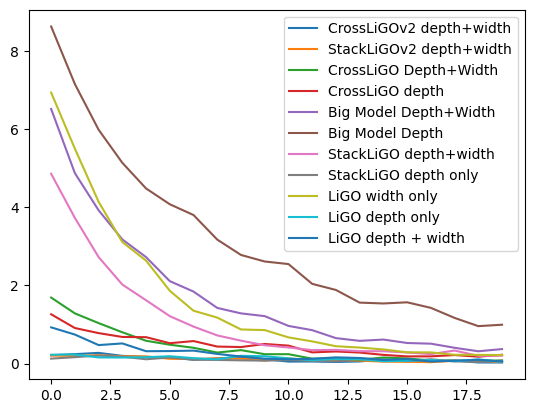

In [54]:
df.plot()

In [ ]:
df.to_pickle('Stack_LiGO_curves')